In [12]:
# Requirements: numpy, sklearn, nltk, matplotlib, plotly

# For Retina Display
%config InlineBackend.figure_format = 'retina'

# Prevent codes being displayed when exporting to an HTML file
import IPython.core.display as di
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) {jQuery(".input_area").toggle(); jQuery(".prompt").toggle();} jQuery(".highlight").show();});</script>', raw=True)

# Dynamically add a button to show/hide codes
di.display_html("<script>jQuery(function() {jQuery(function() {var b = jQuery('<input type=\"button\" value=\"Show/Hide codes\"/>'); b.click(function(){jQuery('.input_area').each(function(){jQuery(this).toggle();});}); jQuery('#References').parent().append(b);});});</script>", raw=True)

# Suppress all warnings
import warnings
warnings.filterwarnings("ignore")


# Project 2: Clustering #

# Dataset: #

Load the dataset for following categories

In [13]:
import numpy as np
import plotly.offline as py
import plotly.graph_objs as go

np.random.seed(42)
import random
random.seed(42)

py.init_notebook_mode(connected=True)

from sklearn.datasets import fetch_20newsgroups

categories = ['comp.sys.ibm.pc.hardware', 'comp.graphics','comp.sys.mac.hardware', 'comp.os.ms-windows.misc', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']
dataset = fetch_20newsgroups(subset='all', categories=categories, shuffle=True, random_state=42)

print(dataset.target_names)

['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']


### 1. Building the TF-IDF matrix. ###

In [14]:
import string
from sklearn.feature_extraction.text import TfidfVectorizer

tfidfVectorizer = TfidfVectorizer(min_df=3, stop_words='english')
tfidfVectors = tfidfVectorizer.fit_transform(dataset.data)
print('When min_df=3, we get %d documents with %d terms.' % (tfidfVectors.shape[0], tfidfVectors.shape[1]))

When min_df=3, we get 7882 documents with 27768 terms.


### 2. Kmeans ###

In [16]:
from sklearn.cluster import KMeans
from sklearn import metrics

vfunc = np.vectorize(lambda t : int(t / 4))
labels = vfunc(dataset.target)

true_k = 2
kmeans = KMeans(n_clusters = true_k, random_state=0, max_iter=1000, n_init=30)
kmeans.fit(tfidfVectors)

import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
%matplotlib inline

from sklearn.metrics.cluster import contingency_matrix
from sklearn.metrics.cluster import homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score, adjusted_mutual_info_score

def evaluate(labels, kmeans_labels_):
    print("Homogeneity: %.6f" % homogeneity_score(labels,kmeans_labels_))
    print("Completeness: %.6f" % completeness_score(labels,kmeans_labels_))
    print("V-measure: %.6f" % v_measure_score(labels,kmeans_labels_))
    print("Adjusted Rand-Index: %.6f" % adjusted_rand_score(labels,kmeans_labels_))
    print("Adjusted Mutual Information Score: %.6f" % adjusted_mutual_info_score(labels,kmeans_labels_))
    matrix = contingency_matrix(labels,kmeans_labels_).astype(int)
    if len(np.unique(labels)) > 2:
        print(plt.matshow(matrix, cmap=get_cmap('Blues')))
    else:
        print(matrix)


evaluate(labels, kmeans.labels_)

Homogeneity: 0.253596
Completeness: 0.334816
V-measure: 0.288600
Adjusted Rand-Index: 0.180762
Adjusted Mutual Information Score: 0.253528
[[   4 3899]
 [1718 2261]]


### 3. Dimension Reduction ###

In [17]:
# Question 4:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components = 1000, n_iter = 7, random_state = 42)
lsiVectors = svd.fit_transform(tfidfVectors)

var = svd.explained_variance_ratio_
var_sum = var.sum() # Can be omitted
# Result array
percent_of_var = [0 for i in range(1000)] 
# Initialize the 1st element of the percent of variance array to 1st element of svd.explained_variance_ratio_ array
percent_of_var[0] = var[0]

for i in range(1,1000):
    percent_of_var[i] = percent_of_var[i-1] + var[i]

In [18]:
def plot_variance(y):
    trace1 = go.Scatter(x=[x for x in range(1,1001)], 
                        y=y, 
                        mode='lines', 
                        line=dict(color='darkorange', width=2), 
                        name='Percent of Variance')
    
    trace2 = go.Scatter(x=[x for x in range(1001)], y=[1 for i in range(1001)], 
                        mode='lines', 
                        line=dict(color='navy', width=2, dash='dash'),
                        showlegend=False)
    
    layout = go.Layout(xaxis=dict(title='R', ticks='outside', mirror=True, linewidth=1),
                       yaxis=dict(title='Percent of Variance', ticks='outside', mirror=True, linewidth=1, range=[0, 1.05]), 
                       legend=dict(x=.7, y=.07, bordercolor='#D3D3D3', borderwidth=1))
    
    fig = go.Figure(data=[trace1, trace2], layout=layout)
    py.iplot(fig)
    
plot_variance(percent_of_var)

In [19]:
# Question 5:
def plot_scores(x, scores, title):
    data = []
    legend = ['Homogeneity', 'Completeness', 'V-measure', 'Adjusted Rand', 'Adjusted Mutual Info']
    width, height = 800, 600

    for i in range(5):
        trace1 = go.Scatter(x=x, y=scores[i], 
                            mode='lines', 
                            line=dict(width=2),
                            name=legend[i]
                           )
        data.append(trace1)
    
    layout = go.Layout(title=title,
                       autosize=False,
                       width=width,
                       height=height,
                       xaxis=dict(title='R', type='log', ticks='outside', mirror=True, linewidth=1),
                       yaxis=dict(title='Scores', ticks='outside', mirror=True, linewidth=1, range=[0, 1]),
                       legend=dict(x=.7, y=.9, bordercolor='#D3D3D3', borderwidth=1))
    
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)

In [20]:
# SVD in specified r (1,2,3,5,10,20,50,100,300) 
r = [1,2,3,5,10,20,50,100,300]
svd_scores = [[],[],[],[],[]]

for i in r:
    kmeans.fit(lsiVectors[:,:i])
    print lsiVectors[:,:i].shape
    svd_scores[0].append(metrics.homogeneity_score(labels, kmeans.labels_))
    svd_scores[1].append(metrics.completeness_score(labels, kmeans.labels_))
    svd_scores[2].append(metrics.v_measure_score(labels, kmeans.labels_))
    svd_scores[3].append(metrics.adjusted_rand_score(labels, kmeans.labels_))
    svd_scores[4].append(metrics.adjusted_mutual_info_score(labels, kmeans.labels_))

plot_scores(r, svd_scores, 'SVD')

(7882, 1)
(7882, 2)
(7882, 3)
(7882, 5)
(7882, 10)
(7882, 20)
(7882, 50)
(7882, 100)
(7882, 300)


In [21]:

from sklearn.decomposition import NMF

nmf_scores = [[],[],[],[],[]]

for i in range(len(r)):
    nmf = NMF(n_components = r[i], random_state=42)
    print r[i]
    nmfVectors = nmf.fit_transform(tfidfVectors)
    print nmfVectors.shape
    kmeans.fit(nmfVectors)
    nmf_scores[0].append(metrics.homogeneity_score(labels, kmeans.labels_))
    nmf_scores[1].append(metrics.completeness_score(labels, kmeans.labels_))
    nmf_scores[2].append(metrics.v_measure_score(labels, kmeans.labels_))
    nmf_scores[3].append(metrics.adjusted_rand_score(labels, kmeans.labels_))
    nmf_scores[4].append(metrics.adjusted_mutual_info_score(labels, kmeans.labels_))

plot_scores(r, nmf_scores, 'NMF')

1
(7882, 1)
2
(7882, 2)
3
(7882, 3)
5
(7882, 5)
10
(7882, 10)
20
(7882, 20)
50
(7882, 50)
100
(7882, 100)
300
(7882, 300)


### 4. (a) Visualization ###

In [43]:
def plot_clusters(X, k_means, title='Title',show_center = False):
    colors = ['#92A8D1', '#F7CAC9', '#F7CAC9', '#F7CAC9', '#F7CAC9', 
              '#F7CAC9', '#e6194b', '#3cb44b', '#3cb44b', '#3cb44b', 
              '#3cb44b', '#ffe119', '#ffe119', '#ffe119', '#ffe119', 
              '#f58231', '#911eb4', '#911eb4', '#911eb4', '#911eb4']
    
    data = []
    
    for k in range(len(k_means.cluster_centers_)):
        my_members = k_means.labels_ == k
        cluster_center = k_means.cluster_centers_[k]
        kmeans1 = go.Scatter(x=X[my_members, 0], y=X[my_members, 1],
                             showlegend=False,
                             mode='markers', 
                             marker=dict(color=colors[k], size=4), 
                             name='cluster ' + str(k))
        kmeans2 = go.Scatter(x=[cluster_center[0]], y=[cluster_center[1]],
                             showlegend=False,
                             mode='markers', 
                             marker=dict(color=colors[k], size=14, 
                                         line=dict(color='black', width=1)))
        data.append(kmeans1)
        if show_center: data.append(kmeans2)

    layout = go.Layout(title=title,
                       autosize=False,
                       width=600,
                       height=600,
                       xaxis=dict(showticklabels=False, ticks='', zeroline=False, showgrid=False),
                       yaxis=dict(showticklabels=False, ticks='', zeroline=False, showgrid=False))

    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)

In [55]:
def plot_groundtruth_clusters(X, labels, title='Title',show_center = False):
    colors = ['#3cb44b','#f58231','#92A8D1', '#F7CAC9', '#F7CAC9', 
              '#F7CAC9', '#F7CAC9', '#F7CAC9', '#e6194b', '#3cb44b', 
              '#3cb44b', '#3cb44b', '#ffe119', '#ffe119', '#ffe119',
              '#ffe119', '#911eb4', '#911eb4', '#911eb4', '#911eb4']
    print X.shape
    print labels
    
    
    data = []

    for k in range(2):
        my_members = labels == k
#         cluster_center = k_means.cluster_centers_[k]
        kmeans1 = go.Scatter(x=X[my_members, 0], y=X[my_members, 1],
                             showlegend=False,
                             mode='markers', 
                             marker=dict(color=colors[k], size=4), 
                             name='cluster ' + str(k))
#         kmeans2 = go.Scatter(x=[cluster_center[0]], y=[cluster_center[1]],
#                              showlegend=False,
#                              mode='markers', 
#                              marker=dict(color=colors[k], size=14, 
#                                          line=dict(color='black', width=1)))
        data.append(kmeans1)
#         if show_center: data.append(kmeans2)

    layout = go.Layout(title=title,
                       autosize=False,
                       width=600,
                       height=600,
                       xaxis=dict(showticklabels=False, ticks='', zeroline=False, showgrid=False),
                       yaxis=dict(showticklabels=False, ticks='', zeroline=False, showgrid=False))

    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)

In [56]:
# Question 7:
# Best r for SVD:
best_r_svd = r[svd_scores[2].index(max(svd_scores[2]))]
print('Best r for SVD: %d' % best_r_svd)

svd2 = TruncatedSVD(n_components = best_r_svd, n_iter = 7, random_state = 42)
lsiVectors2 = svd2.fit_transform(tfidfVectors)
kmeans.fit(lsiVectors2)

evaluate(labels, kmeans.labels_)
plot_clusters(lsiVectors2, kmeans, 'Clustering Results for SVD with its best r', True)

Best r for SVD: 2
Homogeneity: 0.594156
Completeness: 0.595348
V-measure: 0.594751
Adjusted Rand-Index: 0.695181
Adjusted Mutual Information Score: 0.594119
[[ 203 3700]
 [3527  452]]
(7882,)


In [57]:
best_r_nmf = r[nmf_scores[2].index(max(nmf_scores[2]))]
print('Best r for NMF: %d' % best_r_nmf)

nmf2 = NMF(n_components = best_r_nmf, random_state = 42)
nmfVectors2 = nmf2.fit_transform(tfidfVectors)
kmeans.fit(nmfVectors2)

evaluate(labels, kmeans.labels_)

plot_clusters(nmfVectors2, kmeans, 'Clustering Results for NMF with its best r', True)

Best r for NMF: 2
Homogeneity: 0.679048
Completeness: 0.680132
V-measure: 0.679590
Adjusted Rand-Index: 0.777018
Adjusted Mutual Information Score: 0.679019
[[3594  309]
 [ 158 3821]]
(7882,)


In [59]:
plot_groundtruth_clusters(lsiVectors2, labels, 'Clustering Results for ground truth', True)
plot_groundtruth_clusters(nmfVectors2, labels, 'Clustering Results for ground truth', True)

(7882, 2)
[0 0 0 ... 0 0 1]


(7882, 2)
[0 0 0 ... 0 0 1]


### (b) Transformation ###

### SVD with Unit Variance###

In [200]:
# Question 8 - 10:
# SVD with unit variance, best r = 3
from sklearn import preprocessing
lsiVectors3 = preprocessing.scale(lsiVectors2)
kmeans.fit(lsiVectors3)
# print(lsiVectors2[1:10,0])
# print(np.mean(lsiVectors2[:,0]))

evaluate(labels, kmeans.labels_)

Homogeneity: 0.226591
Completeness: 0.255742
V-measure: 0.240286
Adjusted Rand-Index: 0.243479
Adjusted Mutual Information Score: 0.226521
[[1752 2151]
 [3735  244]]


In [201]:
plot_clusters(lsiVectors3, kmeans, 'Clustering Results, SVD with unit variance', True)

### SVD with Log ###

In [202]:
# SVD with log
c = 0.01
lsiVectors4 = np.multiply(np.sign(lsiVectors2),np.log(np.absolute(lsiVectors2) + c) - np.log(c))
kmeans.fit(lsiVectors4)

evaluate(labels, kmeans.labels_)

Homogeneity: 0.608955
Completeness: 0.608923
V-measure: 0.608939
Adjusted Rand-Index: 0.716072
Adjusted Mutual Information Score: 0.608888
[[3610  293]
 [ 313 3666]]


In [203]:
plot_clusters(lsiVectors4, kmeans, 'Clustering Results, SVD with log', True)

### SVD with Unit Variance and Log ###

In [204]:
# combine transform
# Unit Variance first:
lsiVectors5 = preprocessing.scale(lsiVectors2)
lsiVectors5 = np.multiply(np.sign(lsiVectors5),np.log(np.absolute(lsiVectors5) + c) - np.log(c))
kmeans.fit(lsiVectors5)

evaluate(labels, kmeans.labels_)

Homogeneity: 0.000074
Completeness: 0.000074
V-measure: 0.000074
Adjusted Rand-Index: -0.000013
Adjusted Mutual Information Score: -0.000017
[[1863 2040]
 [1859 2120]]


In [205]:
plot_clusters(lsiVectors5, kmeans, 'Clustering Results, SVD with unit variance and log', True)

### SVD with Log and Unit Variance ###

In [206]:
# combine transform
# log first:
lsiVectors6 = np.multiply(np.sign(lsiVectors2),np.log(np.absolute(lsiVectors2) + c) - np.log(c))
lsiVectors6 = preprocessing.scale(lsiVectors6)
kmeans.fit(lsiVectors6)

evaluate(labels, kmeans.labels_)

Homogeneity: 0.609595
Completeness: 0.609554
V-measure: 0.609574
Adjusted Rand-Index: 0.716502
Adjusted Mutual Information Score: 0.609518
[[ 282 3621]
 [3656  323]]


In [207]:
plot_clusters(lsiVectors6, kmeans, 'Clustering Results, SVD with log and unit variance', True)

In [208]:
# Question 9:
# Yes, “logarithm transformation” may improve the clustering results

### 5. Expand Dataset into 20 categories ###

In [209]:
# 20 classes
dataset = fetch_20newsgroups(subset = 'all', remove = ('headers', 'footers', 'quotes'))
labels = dataset.target
print(dataset.target_names)

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [210]:
tfidfVectorizer = TfidfVectorizer(min_df=3, stop_words='english')
tfidfVectors = tfidfVectorizer.fit_transform(dataset.data)
print('When min_df=3, we get %d documents with %d terms.' % (tfidfVectors.shape[0], tfidfVectors.shape[1]))

When min_df=3, we get 18846 documents with 35684 terms.


### Kmeans ###

Homogeneity: 0.290108
Completeness: 0.372647
V-measure: 0.326238
Adjusted Rand-Index: 0.063183
Adjusted Mutual Information Score: 0.287799
AxesImage(43.2,25.92;223.2x223.2)


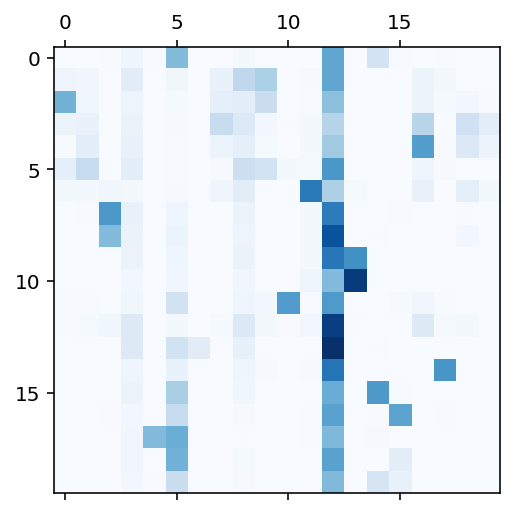

In [217]:
true_k = 20
kmeans = KMeans(n_clusters = true_k, init = 'k-means++')
kmeans.fit(tfidfVectors)

evaluate(labels, kmeans.labels_)

### Dimension Reduction ###

In [218]:
# Reduce dimension to 1000
svd = TruncatedSVD(n_components = 1000, n_iter = 7, random_state = 42)
lsiVectors = svd.fit_transform(tfidfVectors)

var = svd.explained_variance_ratio_
var_sum = var.sum() # Can be omitted
# Result array
percent_of_var = [0 for i in range(1000)] 
# Initialize the 1st element of the percent of variance array to 1st element of svd.explained_variance_ratio_ array
percent_of_var[0] = var[0]

for i in range(1,1000):
    percent_of_var[i] = percent_of_var[i-1] + var[i]

plot_variance(percent_of_var)

In [219]:
def plot_scores(x, scores, title):
    data = []
    legend = ['Homogeneity', 'Completeness', 'V-measure', 'Adjusted Rand', 'Adjusted Mutual Info']
    width, height = 800, 600

    for i in range(5):
        trace1 = go.Scatter(x=x, y=scores[i], 
                            mode='lines', 
                            line=dict(width=2),
                            name=legend[i]
                           )
        data.append(trace1)
    
    layout = go.Layout(title=title,
                       autosize=False,
                       width=width,
                       height=height,
                       xaxis=dict(title='R', ticks='outside', mirror=True, linewidth=1),
                       yaxis=dict(title='Scores', ticks='outside', mirror=True, linewidth=1, range=[0, 1]),
                       legend=dict(x=.7, y=.9, bordercolor='#D3D3D3', borderwidth=1))
    
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)

In [220]:
r = [1,2,3,5,10,20,50,100,300]
svd_scores = [[],[],[],[],[]]

for i in r:
    kmeans.fit(lsiVectors[:,:i])
    svd_scores[0].append(metrics.homogeneity_score(labels, kmeans.labels_))
    svd_scores[1].append(metrics.completeness_score(labels, kmeans.labels_))
    svd_scores[2].append(metrics.v_measure_score(labels, kmeans.labels_))
    svd_scores[3].append(metrics.adjusted_rand_score(labels, kmeans.labels_))
    svd_scores[4].append(metrics.adjusted_mutual_info_score(labels, kmeans.labels_))
    
plot_scores(r, svd_scores, 'SVD')

Best r for SVD: 100
Homogeneity: 0.301816
Completeness: 0.391782
V-measure: 0.340964
Adjusted Rand-Index: 0.061260
Adjusted Mutual Information Score: 0.299544
AxesImage(43.2,25.92;223.2x223.2)


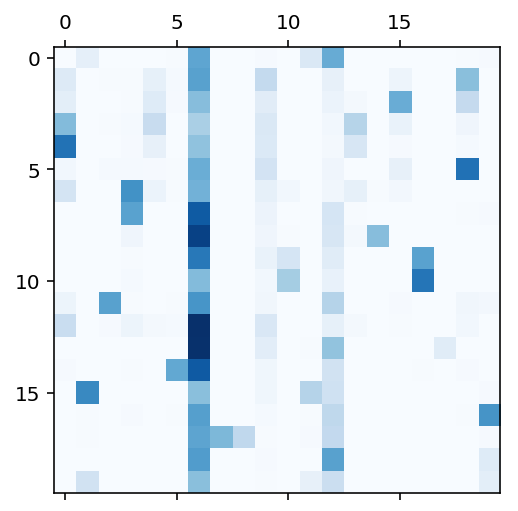

In [221]:
# Best r
# For SVD，the best r = 100
best_r = r[svd_scores[2].index(max(svd_scores[2]))]
print('Best r for SVD: %d' % best_r)

svd2 = TruncatedSVD(n_components = best_r, n_iter = 7, random_state = 42)
lsiVectors2 = svd2.fit_transform(tfidfVectors)
kmeans.fit(lsiVectors2)

evaluate(labels, kmeans.labels_)

### Transformation ###

### SVD with Unit Variance

In [222]:
def plot_transform_scores(x, scores, title):
    data = []
    legend = ['Original', 'Unit Variance', 'Log', 'Unit Variance + Log', 'Log + Unit Variance']
    width, height = 800, 600

    for i in range(5):
        trace1 = go.Scatter(x=x, y=scores[i], 
                            mode='lines', 
                            line=dict(width=2),
                            name=legend[i]
                           )
        data.append(trace1)
    
    layout = go.Layout(title=title,
                       autosize=False,
                       width=width,
                       height=height,
                       xaxis=dict(title='R', ticks='outside', mirror=True, linewidth=1),
                       yaxis=dict(title='Scores', ticks='outside', mirror=True, linewidth=1, range=[0, 1]),
                       legend=dict(x=.7, y=.9, bordercolor='#D3D3D3', borderwidth=1))
    
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)

In [223]:
r = [1,2,3,5,10,20,50,100,300]
svd_scores = [[],[],[],[],[]]
c = 0.01
for i in r:
    # without transformation:
    lsiVectorsTemp = lsiVectors[:,:i]
    kmeans.fit(lsiVectorsTemp)
    svd_scores[0].append(metrics.v_measure_score(labels, kmeans.labels_))
    
    # with unit variance:
    lsiVectors2 = preprocessing.scale(lsiVectorsTemp)
    kmeans.fit(lsiVectors2)
    svd_scores[1].append(metrics.v_measure_score(labels, kmeans.labels_))
    
    # with log:
    lsiVectors3 = np.multiply(np.sign(lsiVectorsTemp),np.log(np.absolute(lsiVectorsTemp) + c) - np.log(c))
    kmeans.fit(lsiVectors3)
    svd_scores[2].append(metrics.v_measure_score(labels, kmeans.labels_))
    
    # with unit variance then log:
    lsiVectors4 = preprocessing.scale(lsiVectorsTemp)
    lsiVectors4 = np.multiply(np.sign(lsiVectors4),np.log(np.absolute(lsiVectors4) + c) - np.log(c))
    kmeans.fit(lsiVectors4)
    svd_scores[3].append(metrics.v_measure_score(labels, kmeans.labels_))
    
    # with log then unit variance:
    lsiVectors5 = np.multiply(np.sign(lsiVectorsTemp),np.log(np.absolute(lsiVectorsTemp) + c) - np.log(c))
    lsiVectors5 = preprocessing.scale(lsiVectors5)
    kmeans.fit(lsiVectors5)
    svd_scores[4].append(metrics.v_measure_score(labels, kmeans.labels_))

In [224]:
plot_transform_scores(r, svd_scores, 'V-measure of SVD with transformation')